In [1]:
!pip install transformers torch plotly

from transformers import AutoTokenizer, AutoModelForTokenClassification
import torch
import zlib
from dataclasses import dataclass
from typing import List, Tuple, Dict, Any
from IPython.display import HTML, display
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go


In [2]:
@dataclass
class BPMNConfig:
    model_name: str = "jtlicardo/bpmn-information-extraction-v2"
    plantuml_server: str = "http://www.plantuml.com/plantuml/svg/"

config = BPMNConfig()

def plantuml_encode(text: str) -> str:
    """Кодирование PlantUML в формат URL (deflate + custom base64)."""
    zlibbed = zlib.compress(text.encode("utf-8"))[2:-4]

    def encode6bit(b: int) -> str:
        if b < 10:  return chr(48 + b)
        b -= 10
        if b < 26: return chr(65 + b)
        b -= 26
        if b < 26: return chr(97 + b)
        b -= 26
        if b == 0: return '-'
        if b == 1: return '_'
        return '?'

    encoded = ""
    for i in range(0, len(zlibbed), 3):
        b1 = zlibbed[i]
        b2 = zlibbed[i+1] if i+1 < len(zlibbed) else 0
        b3 = zlibbed[i+2] if i+2 < len(zlibbed) else 0

        c1 = b1 >> 2
        c2 = ((b1 & 0x3) << 4) | (b2 >> 4)
        c3 = ((b2 & 0xF) << 2) | (b3 >> 6)
        c4 = b3 & 0x3F

        encoded += (
            encode6bit(c1) +
            encode6bit(c2) +
            encode6bit(c3) +
            encode6bit(c4)
        )
    return encoded


In [3]:
class BPMNExtractor:
    def __init__(self, cfg: BPMNConfig):
        self.cfg = cfg
        self.tokenizer = AutoTokenizer.from_pretrained(cfg.model_name)
        self.model = AutoModelForTokenClassification.from_pretrained(cfg.model_name)

    # ---------- 1. Извлечение сущностей ----------
    def extract_entities(self, text: str) -> List[Tuple[str, str]]:
        inputs = self.tokenizer(text, return_tensors="pt")
        with torch.no_grad():
            outputs = self.model(**inputs)

        tokens = self.tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
        predictions = torch.argmax(outputs.logits, dim=-1)[0]

        merged: List[Tuple[str, str]] = []
        current_word = ""
        current_label = None

        print("=== TOKENS + LABELS ===")
        for token, pred in zip(tokens, predictions):
            label = self.model.config.id2label[int(pred)]
            print(f"{token:15} -> {label}")

            if token.startswith("##"):
                current_word += token[2:]
                continue

            if current_word:
                merged.append((current_word, current_label))

            current_word = token
            current_label = label

        if current_word:
            merged.append((current_word, current_label))

        print("\n=== MERGED ENTITIES ===")
        for w, l in merged:
            print(f"{w:25} → {l}")

        return merged

    # ---------- 2. Преобразование в структуру процесса ----------
    def entities_to_structure(self, entities: List[Tuple[str, str]]) -> List[Dict[str, Any]]:
        structure: List[Dict[str, Any]] = []
        cur_word = ""
        cur_type = None

        for word, label in entities:
            low = word.lower()

            # Явно ловим else/otherwise, даже если модель их не пометила
            if low in ["else", "otherwise"]:
                if cur_word:
                    structure.append({"word": cur_word.strip(), "type": cur_type})
                    cur_word = ""
                    cur_type = None
                structure.append({"word": low, "type": "CONDITION"})
                continue

            base = label.split("-")[-1] if label is not None and "-" in label else label

            if base in ["AGENT", "TASK", "CONDITION", "TASK_INFO"]:
                if label.startswith("B-"):
                    if cur_word:
                        structure.append({"word": cur_word.strip(), "type": cur_type})
                    cur_word = word + " "
                    cur_type = base
                elif label.startswith("I-") and cur_type == base:
                    cur_word += word + " "
            else:
                if cur_word:
                    structure.append({"word": cur_word.strip(), "type": cur_type})
                cur_word = ""
                cur_type = None

        if cur_word:
            structure.append({"word": cur_word.strip(), "type": cur_type})

        print("\n=== INTERMEDIATE STRUCTURE ===")
        for s in structure:
            print(s)

        return structure

    # ---------- 3. Генерация BPMN в PlantUML ----------
    def structure_to_bpmn(self, structure: List[Dict[str, Any]]) -> str:
        bpmn: List[str] = ["@startuml"]
        current_lane = None
        inside_if = False

        for item in structure:
            word = item["word"]
            t = item["type"]

            if t == "AGENT":
                if current_lane != word:
                    bpmn.append("|" + word + "|")
                    current_lane = word

            elif t == "CONDITION":
                low = word.lower()
                if low in ["else", "otherwise"]:
                    bpmn.append("else (no)")
                else:
                    bpmn.append(f"if ({word}?) then (yes)")
                    inside_if = True

            elif t == "TASK":
                bpmn.append(f":{word};")

        if inside_if:
            bpmn.append("endif")

        bpmn.append("stop")
        bpmn.append("@enduml")
        return "\n".join(bpmn)

    # ---------- 4. Высокоуровневый BPMN-пайплайн ----------
    def build_bpmn(self, text: str) -> Dict[str, Any]:
        entities = self.extract_entities(text)
        structure = self.entities_to_structure(entities)
        plantuml_text = self.structure_to_bpmn(structure)
        encoded = plantuml_encode(plantuml_text)
        url = self.cfg.plantuml_server + encoded
        return {
            "entities": entities,
            "structure": structure,
            "plantuml": plantuml_text,
            "url": url
        }

    # ---------- 5. Подсветка сущностей с группировкой ----------
    def visualize_entities(self, merged_entities: List[Tuple[str, str]]):
        COLOR_MAP = {
            "AGENT": "#7FDBFF",
            "TASK": "#FFDC00",
            "CONDITION": "#FF851B",
            "TASK_INFO": "#2ECC40",
            "O": "#DDDDDD",
        }

        grouped = []
        cur_text = ""
        cur_label = None

        # Группируем по BIO: B-XXX / I-XXX → одна сущность
        for word, label in merged_entities:
            base = label.split("-")[-1] if label is not None and "-" in label else label

            if base in ["AGENT", "TASK", "CONDITION", "TASK_INFO"]:
                if label.startswith("B-"):
                    if cur_text:
                        grouped.append((cur_text.strip(), cur_label))
                    cur_text = word + " "
                    cur_label = base
                elif label.startswith("I-") and cur_label == base:
                    cur_text += word + " "
            else:
                if cur_text:
                    grouped.append((cur_text.strip(), cur_label))
                    cur_text = ""
                    cur_label = None
                grouped.append((word, "O"))

        if cur_text:
            grouped.append((cur_text.strip(), cur_label))

        html = "<div style='font-family:Arial; line-height:2.0;'>"
        for text, label in grouped:
            color = COLOR_MAP.get(label, "#AAAAAA")
            label_disp = label if label != "O" else ""
            html += (
                f"<span style='background:{color}; padding:4px 8px; margin:4px; "
                f"border-radius:8px; display:inline-block;'>"
                f"{text}"
            )
            if label_disp:
                html += f" <small style='opacity:0.6'>{label_disp}</small>"
            html += "</span>"
        html += "</div>"

        display(HTML(html))


In [4]:
class ResourceAnalyzer:
    def __init__(self, plantuml_server: str):
        self.plantuml_server = plantuml_server

    # ---------- 1. Переходы AGENT → AGENT ----------
    def compute_resource_transitions(self, structure: List[Dict[str, Any]]) -> Dict[Tuple[str, str], int]:
        agents_sequence = [item["word"] for item in structure if item["type"] == "AGENT"]

        freq: Dict[Tuple[str, str], int] = {}
        for i in range(len(agents_sequence) - 1):
            a1 = agents_sequence[i]
            a2 = agents_sequence[i + 1]
            if a1 != a2:
                freq[(a1, a2)] = freq.get((a1, a2), 0) + 1

        return freq

    # ---------- 2. Матрица взаимодействий (AGENT x AGENT) ----------
    def build_interaction_matrix(self, structure: List[Dict[str, Any]]):
        freq = self.compute_resource_transitions(structure)

        if not freq:
            return [], np.zeros((0, 0), dtype=int)

        agents = sorted({a for pair in freq for a in pair})
        size = len(agents)
        M = np.zeros((size, size), dtype=int)

        index = {agent: i for i, agent in enumerate(agents)}
        for (a1, a2), count in freq.items():
            i = index[a1]
            j = index[a2]
            M[i, j] = count

        return agents, M


    # ---------- 3. Heatmap взаимодействий ----------
    def visualize_heatmap(self, structure: List[Dict[str, Any]]):
        agents, M = self.build_interaction_matrix(structure)
        if len(agents) == 0:
            print("No interactions to show.")
            return

        plt.figure(figsize=(7, 6))
        plt.imshow(M)  # без явного cmap, чтобы не задавать стиль
        plt.colorbar(label="Interaction frequency")

        plt.xticks(range(len(agents)), agents, rotation=45, ha="right")
        plt.yticks(range(len(agents)), agents)

        plt.title("Resource Interaction Heatmap")
        plt.tight_layout()
        plt.show()

    # ---------- 4. Sankey диаграмма ----------
    def visualize_sankey(self, structure: List[Dict[str, Any]]):
        freq = self.compute_resource_transitions(structure)
        if not freq:
            print("No interactions to show.")
            return

        agents = sorted({a for pair in freq for a in pair})
        index = {a: i for i, a in enumerate(agents)}

        sources = []
        targets = []
        values = []

        for (a1, a2), count in freq.items():
            sources.append(index[a1])
            targets.append(index[a2])
            values.append(count)

        fig = go.Figure(data=[go.Sankey(
            node=dict(
                pad=15,
                thickness=20,
                line=dict(width=0.5),
                label=agents,
            ),
            link=dict(
                source=sources,
                target=targets,
                value=values
            ))])

        fig.update_layout(title_text="Resource Flow (Sankey Diagram)", font_size=12)
        fig.show()


In [5]:
bpmn_extractor = BPMNExtractor(config)
resource_analyzer = ResourceAnalyzer(config.plantuml_server)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/347 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/431M [00:00<?, ?B/s]

=== TOKENS + LABELS ===
[CLS]           -> O
The             -> B-AGENT
customer        -> I-AGENT
submit          -> B-TASK
##s             -> I-TASK
a               -> I-TASK
re              -> I-TASK
##fu            -> I-TASK
##nd            -> I-TASK
request         -> I-TASK
,               -> O
the             -> B-AGENT
support         -> I-AGENT
agent           -> I-AGENT
reviews         -> B-TASK
the             -> I-TASK
request         -> I-TASK
and             -> O
if              -> B-CONDITION
the             -> I-CONDITION
request         -> I-CONDITION
is              -> I-CONDITION
valid           -> I-CONDITION
,               -> O
the             -> B-AGENT
finance         -> I-AGENT
department      -> I-AGENT
approve         -> B-TASK
##s             -> I-TASK
the             -> I-TASK
re              -> I-TASK
##fu            -> I-TASK
##nd            -> I-TASK
,               -> O
the             -> B-AGENT
system          -> I-AGENT
processes       -> B-TASK
the 


=== PLANTUML BPMN ===
@startuml
|The customer|
:submits a refund request;
|the support agent|
:reviews the request;
if (if the request is valid?) then (yes)
|the finance department|
:approves the refund;
|the system|
:processes the payment;
|the customer|
:receives a confirmation email;
else (no)
|the support agent|
:informs the customer;
endif
stop
@enduml



=== INTERACTION MATRIX + HEATMAP ===
Agents: ['The customer', 'the customer', 'the finance department', 'the support agent', 'the system']
Matrix:
 [[0 0 0 1 0]
 [0 0 0 1 0]
 [0 0 0 0 1]
 [0 0 1 0 0]
 [0 1 0 0 0]]


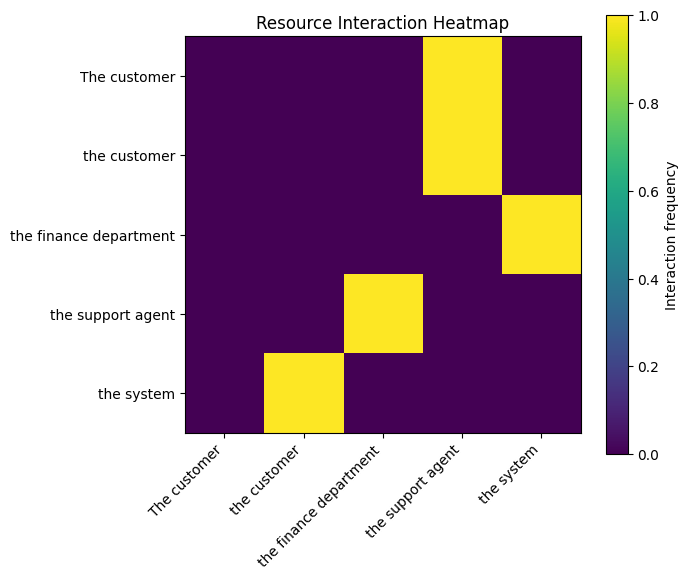


=== SANKEY ===


In [9]:
text = """
The customer submits a refund request, the support agent reviews the request
and if the request is valid, the finance department approves the refund, the system processes the payment, the customer receives a confirmation email
else the support agent informs the customer.
"""

# 1. Строим BPMN
result = bpmn_extractor.build_bpmn(text)
structure = result["structure"]

# 2. Подсветка сущностей
print("\n=== ENTITY HIGHLIGHTING ===")
bpmn_extractor.visualize_entities(result["entities"])

print("\n=== PLANTUML BPMN ===")
print(result["plantuml"])
display(HTML(f'<img src="{result["url"]}">'))
display(HTML(f'<a href="{result["url"]}" target="_blank">{result["url"]}</a>'))

# 3. Матрица + Heatmap
print("\n=== INTERACTION MATRIX + HEATMAP ===")
agents, M = resource_analyzer.build_interaction_matrix(structure)
print("Agents:", agents)
print("Matrix:\n", M)
resource_analyzer.visualize_heatmap(structure)

# 4. Sankey
print("\n=== SANKEY ===")
resource_analyzer.visualize_sankey(structure)
